In [1]:
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os
from scipy import interpolate
from models import *
from IPython import display

### Model Parameters

#### stellar_params
| parameter 	| default value 	|                                          definition 	|
|-----------	|:-------------:	|----------------------------------------------------:	|
| Ms        	|       1       	|                           mass of protostar in Msun 	|
| Rs        	|       2       	|                         radius of protostar in Msun 	|
| Ts        	|      5000     	|            surface temperature of protostar in Msun 	|
| accrate   	|      1e-7     	|            accretion rate onto protostar in Msun/yr 	|
| f         	|      0.01     	| fraction of stellar surface accretion columns cover 	|

#### disk_params

| parameter 	| default value 	|                                                                       definition 	|
|-----------	|:-------------:	|---------------------------------------------------------------------------------:	|
| Mdisk     	|      0.06     	|                                                          total disk mass in Msun 	|
| Mfrac     	|  [0.01,0.01]  	|                   list: fraction of mass in dust for [small grains,large grains] 	|
| R0        	|     [5,5]     	|                            inner radius of [gas+small grains,large grains] in au 	|
| Rout      	|    [100,50]   	|                          outer radius for [gas+small grains, large grains] in au 	|
| H0        	|    [1,0.2]    	|            fraction of gas scale height occupied by [small grains, large grains] 	|
| p         	|    [-1,-1]    	|       power law of surface density profile for [gas+small grains, large grains]  	|
| Rdisk     	|    [60,30]    	| exponential tail of surface density profile for [gas+small grains, large grains] in au 	|

#### envelope_params

| parameter 	| default value 	|                                                 definition 	|
|-----------	|:-------------:	|-----------------------------------------------------------:	|
| Min       	|      1e-6     	|                  mass infall rate from envelope in Msun/yr 	|
| Rc        	|       60      	|                         centrifugal radius of infall in au 	|
| rho_amb   	|     1e-25     	|                   ambient density of environment in g/cm^3 	|
| rho_0     	|     3e-22     	|                        density at base of cavity in g/cm^3 	|
| exf       	|      0.25     	|          power law exponent for density decrease in cavity 	|
| theta_min 	|       15      	|                       opening angle of envelope in degrees 	|
| Rmax      	|      5e5      	|                               outer edge of envelope in au 	|
| d2g       	|      0.01     	|             dust to gas ratio in envelope for small grains 	|
| shock     	|      True     	| whether a shock surface compression/heating layer is added 	|

#### grid_params

*note: assumes 3-D mirror symmetry for radmc3d, so keep phi coverage over 2pi
*downsampling r or theta can have unintended consequences in the interpolation, be careful

| parameter 	|  default value 	|                                      definition 	|
|-----------	|:--------------:	|------------------------------------------------:	|
| N         	|  [180,180,48]  	|          number of grid points in [r,theta,phi] 	|
| min       	|  [0.1,pi/16,0] 	|   minimum value of grid points in [r,theta,phi] 	|
| max       	| [400,pi/2,2pi] 	| maximum value of grid points in [r, theta, phi] 	|
| spacing   	|  [log,lin,lin] 	|              spacing of points in [r,theta,phi] 	|

#### dust_params
*used to compute with optool calculations, if using your own opacity files and doing chemistry later, input these values to make sure consistency with chemistry happens

| parameter 	| default value 	|                                                     definition 	|
|-----------	|:-------------:	|---------------------------------------------------------------:	|
| rho_si    	|     3.1518    	|  material density of grains from optool calculations in g/cm^3 	|
| amin      	| [0.005,0.005] 	| minimum grain size for [small grains, large grains] in microns 	|
| amax      	|    [1,1e3]    	| maximum grain size for [small grains, large grains] in microns 	|
| apow      	|      3.5      	|                           slope of dn/da of grain distribution 	|

#### RT_params

| parameter       	| default value 	|                                          definition 	|
|-----------------	|:-------------:	|----------------------------------------------------:	|
| G0              	|       1       	|                              strength of ISRF in G0 	|
| viscous_heating 	|      True     	|      whether to include heat from viscous accretion 	|
| cr_model        	|     'ssx'     	| model used for computing cosmic ray ionization rate 	|
| zetacr          	|    1.3e-17    	|               base cosmic ray ionization rate in /s 	|

In [3]:
rc = 105
rd = 60
md = 0.015*0.7

In [4]:
# total flux depends on masses and most common temperatures of different components
# argument is that you can recover the same flux density variation 

In [10]:
# %load l1527.py
# T-Tauri Star L1527 typ
par0 = {}
par0['Ms'] = 1.0
par0['Rs'] = 2.0
par0['Ts'] = 4000.
par0['Min'] = 3e-6
par0['Rmax'] = 1.5e4
par0['theta_min'] = 15
par0['Rc'] = rc
par0['Mdisk'] = md
par0['Mfrac'] = [0.005,0.005]
par0['R0'] = [1,1]
par0['Rdisk'] = [rc,rc]
par0['H0'] = [1,0.3]
par0['shock'] = True
par0['N'] = [400,90,90]
par0['min'] = [2, 0.19634954084936207, 0]

md0=initialize_model(par0,outdir='/noshear/')

stellar_params: {'Ms': 1.0, 'Rs': 2.0, 'Ts': 4000.0, 'accrate': 1e-07, 'f': 0.01}
disk_params: {'Mdisk': 0.010499999999999999, 'Mfrac': [0.005, 0.005], 'R0': [1, 1], 'Rout': [100, 50], 'H0': [1, 0.3], 'p': [-1, -1], 'fi': [0.25, 0.25], 'Rdisk': [105, 105]}
envelope_params: {'Min': 3e-06, 'Rc': 105, 'rho_amb': 1e-25, 'rho_0': 3e-22, 'theta_min': 15, 'exf': 0.25, 'Rmax': 15000.0, 'd2g': 0.01, 'shock': True}
grid_params: {'N': [400, 90, 90], 'min': [2, 0.19634954084936207, 0], 'max': [400, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 3.1518, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': 3.5}
RT_params: {'cr_model': 'ssx', 'zetacr': 1.3e-17, 'LX': 1e+30, 'G0': 1, 'viscous_heating': True}
directory exists - will overwrite current model if you write to it!
Reading wavelength_micron.inp
Writing wavelength_micron.inp
Reading wavelength_micron.inp
Writing stars.inp
Reading amr_grid.inp
Reading wavele

In [43]:
# %load params.py
noshear_params = 
{'Ms': 0.2, 
'Rs': 2.0, 
'Ts': 4000.0, 
'accrate': 1e-07, 
'f': 0.01, 
'Mdisk': 0.010499999999999999, 
'Mfrac': [0.005, 0.005], 
'R0': [1, 1],  
'H0': [1, 0.3], 
'Rdisk': [105, 105], 
'Min': 3e-06, 
'Rc': 105, 
'theta_min': 15,  
'Rmax': 15000.0, 
'd2g': 0.01, 
'shock': True, 
'N': [120, 90, 48], 
'min': [0.5, 0.19634954084936207, 0]
}

In [10]:
# %load l1527.py
# T-Tauri Star L1527 type
par1 = {}
par1['Ms'] = 0.2
par1['Rs'] = 2.0
par1['Ts'] = 4000.
par1['Min'] = 8e-6
par1['Rmax'] = 1.5e4
par1['theta_min'] = 15
par1['Rc'] = rc
par1['Mdisk'] = md*np.sqrt(rd/rc)
par1['Mfrac'] = [0.005,0.005]
par1['R0'] = [1,1]
par1['Rdisk'] = [rd,rd]
par1['H0'] = [1,0.3]
par1['shock'] = False
par1['N'] = [120,90,48]
par1['min'] = [1, 0.19634954084936207, 0]

md1=initialize_model(par1,outdir='/shear1/')


stellar_params: {'Ms': 0.2, 'Rs': 2.0, 'Ts': 4000.0, 'accrate': 1e-07, 'f': 0.01}
disk_params: {'Mdisk': 0.00793725393319377, 'Mfrac': [0.005, 0.005], 'R0': [1, 1], 'Rout': [100, 50], 'H0': [1, 0.3], 'p': [-1, -1], 'fi': [0.25, 0.25], 'Rdisk': [60, 60]}
envelope_params: {'Min': 8e-06, 'Rc': 105, 'rho_amb': 1e-25, 'rho_0': 3e-22, 'theta_min': 15, 'exf': 0.25, 'Rmax': 15000.0, 'd2g': 0.01, 'shock': False}
grid_params: {'N': [120, 90, 48], 'min': [1, 0.19634954084936207, 0], 'max': [400, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 3.1518, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': 3.5}
RT_params: {'cr_model': 'ssx', 'zetacr': 1.3e-17, 'LX': 1e+30, 'G0': 1, 'viscous_heating': True}
directory exists - will overwrite current model if you write to it!
Reading wavelength_micron.inp
Writing wavelength_micron.inp
Reading wavelength_micron.inp
Writing stars.inp
Reading amr_grid.inp
Reading waveleng

In [11]:
par2 = {}
par2['Ms'] = 0.2
par2['Rs'] = 2.0
par2['Ts'] = 4000.
par2['Min'] = 8.0e-6
par2['Rmax'] = 1.5e4
par2['theta_min'] = 15
par2['Rc'] = rc
par2['Mdisk'] = md*np.sqrt(rd/rc)
par2['Mfrac'] = [0.005,0.005]
par2['R0'] = [1,1]
par2['Rdisk'] = [rd,rd]
par2['H0'] = [1,0.3]
par2['shock'] = True
par2['N'] = [120,90,48]
par2['min'] = [1, 0.19634954084936207, 0]

md2=initialize_model(par2,outdir='/shear2/')

stellar_params: {'Ms': 0.2, 'Rs': 2.0, 'Ts': 4000.0, 'accrate': 1e-07, 'f': 0.01}
disk_params: {'Mdisk': 0.00793725393319377, 'Mfrac': [0.005, 0.005], 'R0': [1, 1], 'Rout': [100, 50], 'H0': [1, 0.3], 'p': [-1, -1], 'fi': [0.25, 0.25], 'Rdisk': [60, 60]}
envelope_params: {'Min': 8e-06, 'Rc': 105, 'rho_amb': 1e-25, 'rho_0': 3e-22, 'theta_min': 15, 'exf': 0.25, 'Rmax': 15000.0, 'd2g': 0.01, 'shock': True}
grid_params: {'N': [120, 90, 48], 'min': [1, 0.19634954084936207, 0], 'max': [400, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 3.1518, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': 3.5}
RT_params: {'cr_model': 'ssx', 'zetacr': 1.3e-17, 'LX': 1e+30, 'G0': 1, 'viscous_heating': True}
directory exists - will overwrite current model if you write to it!
Reading wavelength_micron.inp
Writing wavelength_micron.inp
Reading wavelength_micron.inp
Writing stars.inp
Reading amr_grid.inp
Reading wavelengt

stellar_params: {'Ms': 1, 'Rs': 2.0, 'Ts': 5000, 'accrate': 1e-07, 'f': 0.01}
disk_params: {'Mdisk': 0.05, 'Mfrac': [0.01, 0.01], 'R0': [1, 1], 'Rout': [100, 50], 'H0': [1, 0.3], 'p': [-1, -1], 'fi': [0.25, 0.25], 'Rdisk': [200, 200]}
envelope_params: {'Min': 1e-06, 'Rc': 300, 'rho_amb': 1e-25, 'rho_0': 3e-22, 'theta_min': 45, 'exf': 0.25, 'Rmax': 5000.0, 'd2g': 0.01, 'shock': True}
grid_params: {'N': [250, 90, 48], 'min': [0.1, 0.09817477042468103, 0], 'max': [2500, 1.5707963267948966, 6.283185307179586], 'spacing': ['log', 'lin', 'lin']}
dust_params: {'rho_si': 3.1518, 'amin_chem': 0.06, 'amax_ism': 1.0, 'amin': [0.005, 0.005], 'amax': [1, 1000.0], 'apow': [3.5, 3.5]}
RT_params: {'cr_model': 'ssx', 'zetacr': 1.3e-17, 'G0': 1, 'viscous_heating': False, 'fLya': 0.0001}
directory exists - will overwrite current model if you write to it!
Reading wavelength_micron.inp
Writing wavelength_micron.inp
Reading wavelength_micron.inp
Writing stars.inp
Reading amr_grid.inp
Reading wavelength_micr

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Reading wavelength_micron.inp
Reading wavelength_micron.inp
Writing mcmono_wavelength_micron.inp
Reading wavelength_micron.inp


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


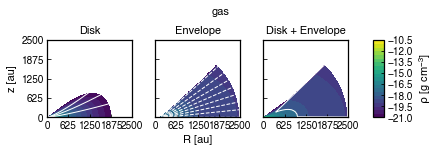

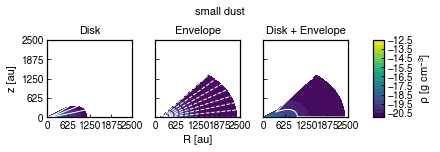

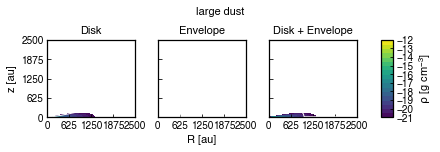

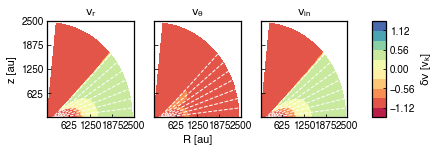

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


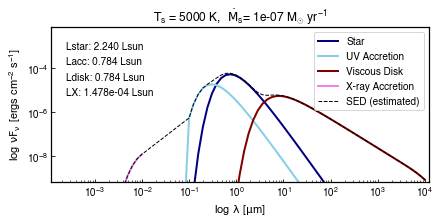

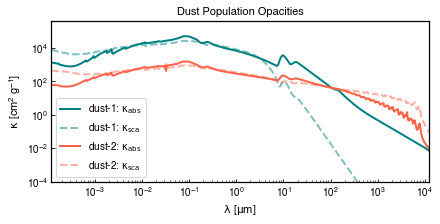

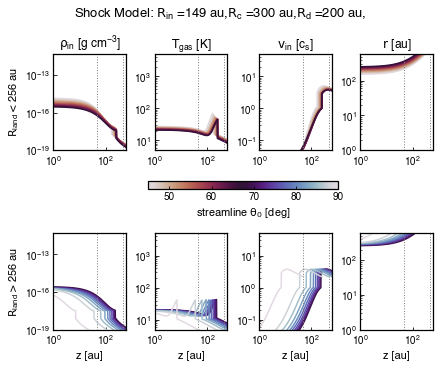

In [38]:
p1 = {'Ms': 1, 'Rs': 2.0, 'Ts': 5000, 'accrate':1e-7,'f':0.01, 'Mdisk': 0.05, 'Mfrac': [0.01,0.01],'R0':[1,1], 'H0':[1,0.3], 'p':[-1,-1], 'Rdisk':[200,200],'Min': 1e-6, 'Rc':300, 'rho_amb':1e-25, 'rho_0': 3e-22,'theta_min':45,'exf':0.25,'Rmax':5e3, 'd2g': 0.01, 'shock':True,'N':[250,90,48], 'min':[0.1,pi/32.,0], 'max':[2500,pi/2.,2*pi], 'spacing':['log','lin','lin'],'rho_si':3.1518, 'amin_chem':0.06, 'amax_ism': 1.0, 'amin': [0.005,0.005], 'amax': [1,1e3], 'apow': [3.5,3.5],'cr_model': 'ssx','zetacr': 1.3e-17, 'LX': 1e30, 'G0':1, 'viscous_heating':False}

m1 = initialize_model(p1,outdir='/out/m1/')

save_setup_fig(m1,rlim=2500)

#prep_thermal_transfer(m1,nphot=100000)

#print('ready to do thermal montecarlo!')

#do_thermal_transfer(m0,nt=8)
#print('thermal monte carlo done!')

#save_dustRT(m0)

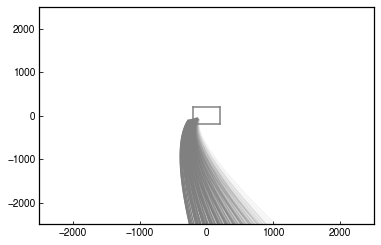

In [39]:
model = m1.m
thstart = np.radians(model.env['theta_min'])
c = 0
for j in np.linspace(thstart+0.01,pi/2-0.01,10):
    for k in np.linspace(3*pi/2-pi/4, 3*pi/2-pi/8, 10):
        c += 0.1
        streamline = model.stream(th0=j,p0=k,shock=True)
        r_s = streamline['path'][0]
        th_s = streamline['path'][1]
        phi_s = streamline['path'][2]

        x_s = r_s*np.cos(phi_s)*np.sin(th_s)
        y_s = r_s*np.sin(phi_s)*np.sin(th_s)


        plot(-x_s,y_s,color='gray',alpha=c)
        xlim(-2500,2500)
        ylim(-2500,2500)
plot([-200,200],[200,200],color='gray')
plot([-200,200],[-200,-200],color='gray')
plot([200,200],[-200,200],color='gray')
plot([-200,-200],[-200,200],color='gray')

### Input Model Structure

#### Disk Density
+ Gas: solved from vertical hydrostatic equilibrium based on the irradiation temperature profile from the blackbody temperature of the star
+ Dust (small): distributed with H0 and flaring index given in input parameters (unless the gas H is smaller), scaled by mass fraction
+ Dust (large): distributed with H0 and flaring index given in input parameters (unless the gas H is smaller), scaled by mass fraction

#### Envelope
+ Gas: computed from streamlines from Ulrich 1976 model 
+ Dust (small): follows gas, with dust to gas parameter specified in envelope parameters, no large dust

*if shock = True*

for every streamline:
shock surface is computed by estimating where ram pressure of incoming streams is matched by local hydrostatic pressure of the disk.

at the shock surface: strong shock is computed from Rankine-Hugoniot jump conditions

downstream from shock surface: rest of shock is modeled with a radiatively cooled region, assuming a cooling function that peaks in the optically thin regime for CO line cooling and exponentially decays downstream until fluid is decelerated to subsonic regime

#### Cavity
+ Gas: cavity whose opening angle is described by minimum impinging angle of incoming streamlines
+ Dust (small): follows gas, with dust to gas parameter specified in envelope parameters, no large dust


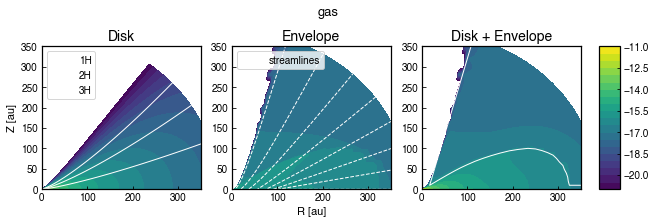

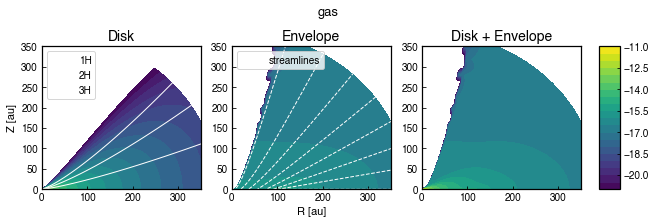

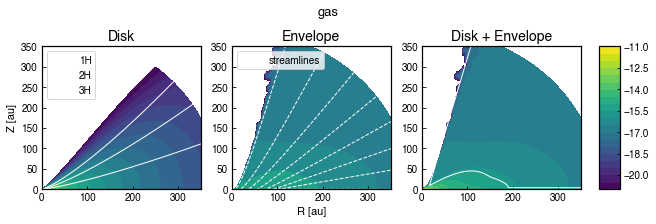

In [7]:
plot_components(md0,0,rlim=350)#gas
plot_components(md1,0,rlim=350)#small dust
plot_components(md2,0,rlim=350)#large dust

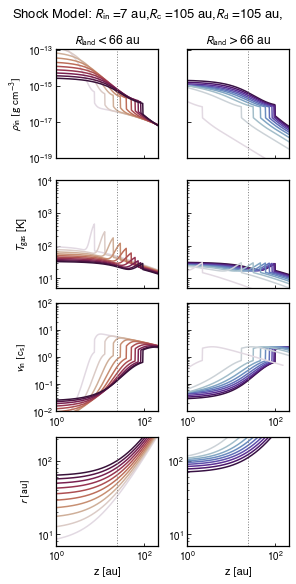

In [9]:
f = plot_shock_model(md0)

In [8]:
def plot_velocities(output,rlim=200):
    model = output.m
    f,ax= subplots(1,3,constrained_layout=True)
    vectors = [r'$v_r$',r'$v_{\theta}$',r'$v_{\rm in}$']
    keys = ['r','theta','phi']
    vmax = np.sqrt(2)*model.vk(R = 50)/1e5
    f.set_size_inches(9,3)
    vfield = model.v_embedded()
    vkep = model.v_disk()['phi']
    #components = {'Disk': model.v_disk(),'Envelope': model.v_env(), 'Disk + Envelope': model.v_embedded()}
    components = dict(zip(vectors, [np.abs(vfield['r']),np.abs(vfield['theta']), np.sqrt(vfield['r']**2 + vfield['theta']**2)]))
    for a,c in zip(ax,components.keys()):
        sca(a)
        dv_field = (components[c]-vkep)/vkep
        levels = np.linspace(-1.4,1.4,11)
        im=plot_slice(output,rho=dv_field,log=False,plot_params={'levels':levels,'cmap':'Spectral'})
        for j in np.linspace(np.radians(model.env['theta_min']),pi/2.,8):
            streamline = model.stream(th0=j,shock=False)
            r = streamline['path'][0]
            th = streamline['path'][1]
            l = a.plot(r*np.sin(th),r*np.cos(th),color='white',ls='dashed',lw=1) #plot streamlines
        a.set_title(c,fontsize=14)
        a.set_xlim(1,rlim)
        a.set_ylim(1,rlim)
    colorbar(im,ax=ax)
    ax[1].set_xlabel('R [au]')
    ax[0].set_ylabel('Z [au]')

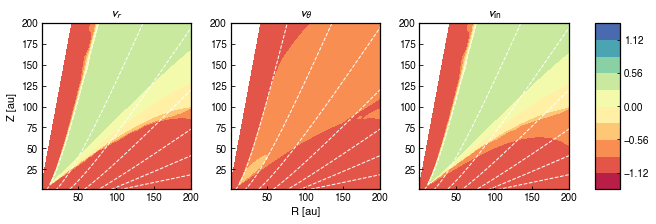

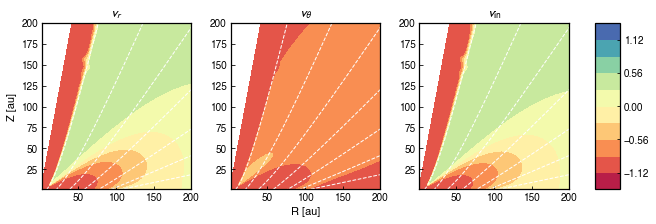

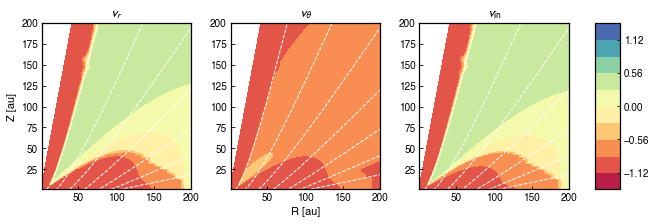

In [12]:
plot_velocities(md0)
plot_velocities(md1)
plot_velocities(md2)

### Do the thermal radiative transfer for the dust

*Files for radmc*: you can put in your own files if you have them, or use the functions in ```write_inputs.py``` to write them
+ amr_grid.inp: ```write_grid``` *writes grid for mirror symmetry in spherical coordinates*
+ dust_density.inp: ```write_dust_density``` *writes dust density based on sum of all three model components*
+ dustkappa_...inp + dustopac.inp: ```update_opacities``` *updates the X-ray end of the opacities to include photo-electric gas opacities*
+ wavelength_micron.inp: ```write_wavelength``` *copies template file in models directory*
+ stars.inp: ```write_star``` *writes a star with uv emission from accretion column*
+ stars.inp: ```insert_xray_radation``` *adds the x-ray radiation from the accretion shock on the stellar surface*
+ heatsource.inp: ```write_viscious_heatsource``` *adds viscous heat source that matches the given steady stellar accretion rate*
+ external_source.inp: ```calc_ISRF``` *scales ISRF from Mathis ISRF file in models directory according to input G0*

*after you have all the files in the model directory*

you can call the```out ``` class defined in ```outputs.py``` to get access to the grids and run radmc3d functions on it

or run radmc3d from the command line. (calling the object will let you access the results from the model itself) 

Reading wavelength_micron.inp
Writing wavelength_micron.inp
Reading wavelength_micron.inp
Writing stars.inp
Accretion rate from infall: 4.123984977101372e-08 Msun/yr
Reading wavelength_micron.inp
Reading wavelength_micron.inp
Writing mcmono_wavelength_micron.inp
Reading wavelength_micron.inp
Reading wavelength_micron.inp
Reading amr_grid.inp
{'lnu_star': array([3.53455169e+33]), 'lnu_accdisk': 6.039491704260927e+32, 'lnu_spot': 6.039491704260927e+32}
Lstar [0.91746961]
Lspot 0.15676811691786963
Ldisk 0.15676811691786963
Reading wavelength_micron.inp
Reading wavelength_micron.inp
Writing mcmono_wavelength_micron.inp


(0.1, 1000)

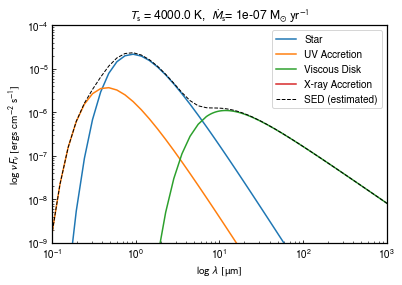

In [34]:
prep_thermal_transfer(md0,infallheat=False)
plot_flux_components(md0)
ylim(1e-9,1e-4)
xlim(0.1,1000)


In [35]:
prep_thermal_transfer(md1,infallheat=False)
prep_thermal_transfer(md2,infallheat=False)
#do_thermal_transfer(md1,prep=False)

Reading wavelength_micron.inp
Writing wavelength_micron.inp
Reading wavelength_micron.inp
Writing stars.inp
Accretion rate from infall: 8.607422210810988e-08 Msun/yr
Reading wavelength_micron.inp
Reading wavelength_micron.inp
Writing mcmono_wavelength_micron.inp
Reading wavelength_micron.inp
Reading wavelength_micron.inp
Reading amr_grid.inp
Reading wavelength_micron.inp
Writing wavelength_micron.inp
Reading wavelength_micron.inp
Writing stars.inp
Accretion rate from infall: 8.607422210810988e-08 Msun/yr
Reading wavelength_micron.inp
Reading wavelength_micron.inp
Writing mcmono_wavelength_micron.inp
Reading wavelength_micron.inp
Reading wavelength_micron.inp
Reading amr_grid.inp


Reading dust_density.inp
Reading dust_temperature.dat


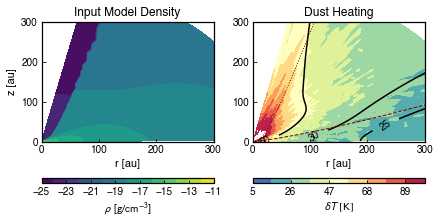

In [36]:
do_thermal_transfer(md0,prep=False,nt=8)
plot_dustRT(md0,rlim=300)

Reading dust_density.inp
Reading dust_temperature.dat


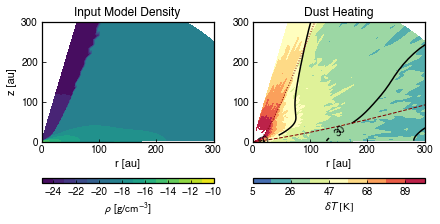

In [37]:
do_thermal_transfer(md1,prep=False,nt=8)
plot_dustRT(md1,rlim=300)

Reading dust_density.inp
Reading dust_temperature.dat


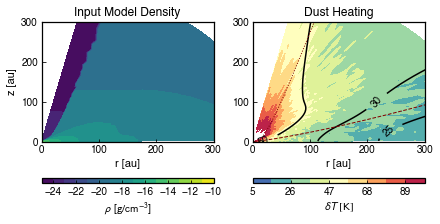

In [38]:
do_thermal_transfer(md2,prep=False,nt=8)
plot_dustRT(md2,rlim=300)

In [14]:
def make_continuum_image(output,envelope=True,**params):
    model=output.m
    write_main(model,scat=1,lines=0)
    if os.getcwd() != model.outdir:
        os.chdir(model.outdir)
    write_dust_density(model,envelope=envelope)
    rpy.image.makeImage(**params)
    im=rpy.image.readImage(binary=False)
    return im

def plot_image(im,**params):
    if 'res_au' in params:
        if 'dpc' in params:
            dpc = params['dpc']
        else:
            dpc = 100
        theta_au = 206265*(AU/(dpc*pc))
        fwhm = theta_au*params['res_au']
        cim = im.imConv(fwhm=[fwhm, fwhm], pa=0., dpc=dpc)
        params['dpc'] = dpc
        del params['res_au']
        rpy.image.plotImage(cim, log=True,arcsec=True,**params)
        print('res required: {} arcsec at {} pc'.format(fwhm,dpc))
    else:
        rpy.image.plotImage(im,log=True,au=True, **params)
        
def plot_radial_slice(im,**params):
    if 'res_au' in params:
        if 'dpc' in params:
            dpc = params['dpc']
        else:
            dpc = 100
        theta_au = 206265*(AU/(dpc*pc))
        fwhm = theta_au*params['res_au']
        imarr = im.imConv(fwhm=[fwhm, fwhm], pa=0., dpc=dpc).image
    else:
        imarr = im.image
    if imarr.ndim > 2:
        imarr = imarr[:,:,int(im.nfreq/2)-1]
    i0 = np.amax(imarr)
    if 'offset_x' in params:
        index = int(im.nx/2) -1 + int(im.nx*params['offset_x']/np.amax(im.x/AU))
        im_slice = imarr[:,index]
        plot(im.x/AU, im_slice/i0,lw=2)
    if 'offset_y' in params:
        index = int(im.ny/2) -1 + int(im.ny*params['offset_y']/np.amax(im.y/AU))
        im_slice = imarr[index,:]
        plot(im.y/AU, im_slice/i0,lw=2)
        
def slice_I(im,dz = 0,**params):
    if 'res_au' in params:
        if 'dpc' in params:
            dpc = params['dpc']
        else:
            dpc = 100
        theta_au = 206265*(AU/(dpc*pc))
        fwhm = theta_au*params['res_au']
        imarr = im.imConv(fwhm=[fwhm, fwhm], pa=0., dpc=dpc).image
    else:
        imarr = im.image
    if imarr.ndim > 2:
        imarr = imarr[:,:,int(im.nfreq/2)-1]
    index = int(im.ny/2) -1 + int(0.5*im.ny*dz/np.amax(im.y/AU))
    im_slice = imarr[index,:]
    return im_slice

def sum_I(im,**params):
    if 'res_au' in params:
        if 'dpc' in params:
            dpc = params['dpc']
        else:
            dpc = 100
        theta_au = 206265*(AU/(dpc*pc))
        fwhm = theta_au*params['res_au']
        imarr = im.imConv(fwhm=[fwhm, fwhm], pa=0., dpc=dpc).image
    else:
        imarr = im.image
    if imarr.ndim > 2:
        imarr = imarr[:,:,int(im.nfreq/2)-1]
    im_slice = np.sum(imarr,axis=0)
    return im_slice
        
def make_radial_I(output, lam=2600,incl=90):
    model=output.m
    write_main(model,scat=1,lines=0)
    if os.getcwd() != model.outdir:
        os.chdir(model.outdir)
    cmd = 'radmc3d image circ lambda {} incl {}'.format(lam,incl)
    os.system(cmd)
    im=rpy.image.readcircimage()
    return im

In [15]:
im_disk = make_continuum_image(md0,envelope=False,wav=870,incl=85,sizeau=300,npix=300)
im_both = make_continuum_image(md0,envelope=True,wav=870,incl=85,sizeau=300,npix=300)


Executing RADMC-3D Command:
radmc3d image npix 300 incl 85 sizeau 300 lambda 870 pointau 0.0  0.0  0.0 fluxcons
Reading image.out
Executing RADMC-3D Command:
radmc3d image npix 300 incl 85 sizeau 300 lambda 870 pointau 0.0  0.0  0.0 fluxcons
Reading image.out


In [16]:
mid_both = slice_I(im_both,dz=0)
mid_disk = slice_I(im_disk,dz=0)
mid_env = mid_both-mid_disk

mid_bc = slice_I(im_both,dz=0,res_au=40,dpc=140)
mid_bd = slice_I(im_disk,dz=0,res_au=40,dpc=140)
mid_be = mid_bc - mid_bd

In [21]:
sum_both = sum_I(im_both)
sum_disk = sum_I(im_disk)
sum_env = sum_both-sum_disk

sum_bc = sum_I(im_both,res_au=40,dpc=140)
sum_bd = sum_I(im_disk,res_au=40,dpc=140)
sum_be = sum_bc - sum_bd

In [17]:
md0.T2D()

Reading dust_temperature.dat


Text(0, 0.5, 'T [K]')

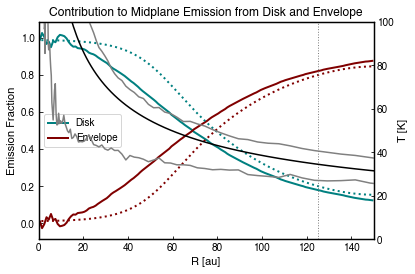

In [20]:
#plot(im_both.x/AU, mid_both)
plot(im_both.x/AU, mid_disk/mid_both,lw=2,color='teal',label="Disk")
plot(im_both.x/AU, mid_env/mid_both,lw=2,color='maroon',label="Envelope")

plot(im_both.x/AU, mid_bd/mid_bc,lw=2,color='teal',ls='dotted')
plot(im_both.x/AU, mid_be/mid_bc,lw=2,color='maroon',ls='dotted')


axvline(125,ls='dotted',lw=1,color='gray')
xlim(0,150)
xlabel('R [au]')
ylabel('Emission Fraction')
title('Contribution to Midplane Emission from Disk and Envelope')
legend()

a2 = gca().twinx()

a2.plot(md0.r, np.average(md0.T['dust'][:,-15:-1],axis=1),color='gray')
a2.plot(md0.r, np.average(md0.T['dust'][:,-45:-30],axis=1),color='gray')
a2.plot(md0.r, md1.m.T(md0.r),color='black')
a2.set_ylim(0,100)
a2.set_ylabel('T [K]')

Text(0, 0.5, 'T [K]')

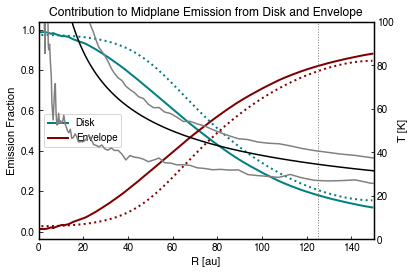

In [22]:
#plot(im_both.x/AU, mid_both)
plot(im_both.x/AU, sum_disk/sum_both,lw=2,color='teal',label="Disk")
plot(im_both.x/AU, sum_env/sum_both,lw=2,color='maroon',label="Envelope")

plot(im_both.x/AU, sum_bd/sum_bc,lw=2,color='teal',ls='dotted')
plot(im_both.x/AU, sum_be/sum_bc,lw=2,color='maroon',ls='dotted')


axvline(125,ls='dotted',lw=1,color='gray')
xlim(0,150)
xlabel('R [au]')
ylabel('Emission Fraction')
title('Contribution to Midplane Emission from Disk and Envelope')
legend()

a2 = gca().twinx()

a2.plot(md0.r, np.average(md0.T['dust'][:,-15:-1],axis=1),color='gray')
a2.plot(md0.r, np.average(md0.T['dust'][:,-45:-30],axis=1),color='gray')
a2.plot(md0.r, md0.m.T(md0.r),color='black')
a2.set_ylim(0,100)
a2.set_ylabel('T [K]')

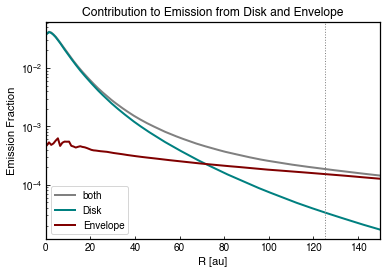

In [23]:
#plot(im_both.x/AU, mid_both)
sum_all = np.sum(sum_both)
plot(im_both.x/AU, sum_both/sum_all,lw=2,color='gray',label="both")
plot(im_both.x/AU, sum_disk/sum_all,lw=2,color='teal',label="Disk")
plot(im_both.x/AU, sum_env/sum_all,lw=2,color='maroon',label="Envelope")

#plot(im_both.x/AU, np.cumsum(mid_bd)/mid_all,lw=2,color='teal',ls='dotted')
#plot(im_both.x/AU, np.cumsum(mid_be)/mid_all,lw=2,color='maroon',ls='dotted')


axvline(125,ls='dotted',lw=1,color='gray')
xlim(0,150)
yscale('log')
xlabel('R [au]')
ylabel('Emission Fraction')
title('Contribution to Emission from Disk and Envelope')
legend()


In [196]:
0.0075*2

0.015

In [199]:
Md(im_both,D=140,kappa=2.8,T=20,d2g=200)

NameError: name 'im_both' is not defined

In [198]:
def Md(im,T=30,kappa=3.1,D=140,d2g=100):
    conv = im.sizepix_x * im.sizepix_y / (D * pc)**2. #flux/pixel
    F_nu = np.sum(im.image*conv)
    nu = im.freq[0]
    Bnu = (2*kb*T*(nu**2))/(c**2)
    Md = d2g*F_nu*(D*pc)**2/(kappa*Bnu)
    return Md/Msun

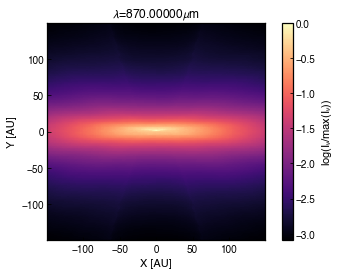

In [30]:
plot_image(im_both,maxlog=5,cmap=cm.magma)

In [478]:
def RJ(lam,T): #lam in microns
    return 2*c*kb*T/((1e-4*lam)**4)
def emission_surface(output,lam = 2600, incl=90,lines=1,dust=1,tau=1):
    model = output.m
    if os.getcwd() != model.outdir:
        os.chdir(model.outdir)
    write_main(output.m,scat=1,lines=lines,dust=dust,noheat=0)
    cmd = 'radmc3d tausurf {} lambda {} incl {}'.format(tau,lam,incl)
    os.system(cmd)
    im=rpy.image.readImage(binary=False)
    return im

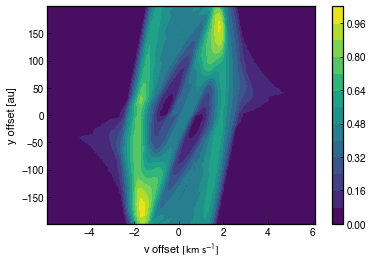

In [171]:
def make_channel_maps(output,envelope=True,params={'iline':1,'widthkms':6,'linenlam':101}):
    model = output.m
    if os.getcwd() != model.outdir:
        os.chdir(model.outdir)
    write_main(output.m,scat=0,dust=0,lines=1,noheat=0)
    rpy.image.makeImage(**params,npix=400,sizeau=400,incl=90)
    im=rpy.image.readImage(binary=False)
    return im
def pv_diagram(im):
    all_im = np.sum(im.image,axis=1)
    nu0 = im.freq[int(im.nfreq/2)-1]
    vkms =  c * (nu0 - im.freq) / nu0 / 1e5
    contourf(vkms,im.x/AU,all_im/np.amax(all_im),levels=12,cmap='viridis')
    xlabel('v offset $\mathrm{[km \ s^{-1}]}$')
    ylabel('y offset [au]')
    colorbar()
    
cm_co21.plotMomentMap(moment=0,wav0=2600.5,au=True,dpc=144,cmap=cm.viridis)
    
pv_diagram(cm_co21)

(0.1, 100)

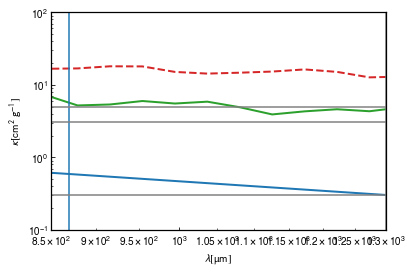

In [71]:
plot_kappa(md1,filename='dust-1',header=True)
plot_kappa(md1, filename='dust-2',header=True)
axvline(870)
axvline(1300,color='gray')
axhline(5,color='gray')
axhline(3.1,color='gray')
axhline(0.3,color='gray')
xlim(850,1300)
ylim(0.1,100)

### Compute Radiation Fields


In [80]:
def prep_he_transfer(output):
    model = output.m
    if os.getcwd() != model.outdir:
        os.chdir(model.outdir)
    write_opacities(model,update=True)
    write_main(model, scat=2, mrw=1, maxtau=20)
    
def do_he_transfer(output,nphot=100000,nt=4,prep=False):
    model = output.m
    if prep == True:
        prep_he_transfer(output)
    if os.getcwd() != model.outdir:
        os.chdir(model.outdir)
    os.system('radmc3d mcmono nphot_mono {} setthreads {}'.format(nphot,nt))


In [77]:
prep_he_transfer(dd1)

In [81]:
do_he_transfer(dd1)

In [40]:

dd1.Jnu(field='uv')
dd1.Jnu(field='xray')


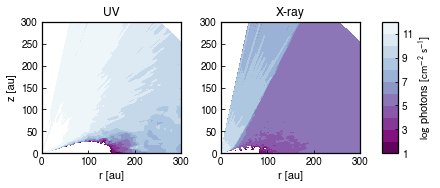

In [7]:
plot_radiation_field(dd1,rlim=300)

In [23]:
def calc_gas_T(output):
    model = output.m
    shock = model.env['shock']
    if output.rho == {}:
        output.rho2D()
    if output.T == {}:
        output.T2D()
    if 'uv' not in output.J.keys():
        output.Jnu(field='uv')
    nG0 = np.log10(np.clip(4*pi*output.integrate_intensity(field='uv')/(G0),a_min=10**-0.5,a_max=10**6.5))
    nH = np.log10(2.*output.rho['gas']/(mu*mh))
    nH_ = np.clip(nH,a_min=1,a_max=7)
    
    T_UV = [model.T_heat(i,j)[0] for i,j in zip(nH_.flatten(), nG0.flatten())]
    T_UV = np.reshape(np.array(T_UV),np.shape(nH)).T
    
    if shock == True:
        T_shock = model.solve_envelope(prop='Tg')[:,:,0]
    else:
        T_shock = np.zeros_like(T_UV)
        
    Tcrit = 130*(10**nH.T/1e10)**(0.3)
    Tgas = np.maximum(T_UV,T_shock)
    
    #if gas temp is below the critical temperature, its coupled to the dust
    coupled = np.where((Tgas-Tcrit)<= 1.0) 
    Tgas[coupled] = 0.0
    T_shock[coupled] = 0.0
    T_UV[coupled] = 0.0
    Tgas = np.maximum(Tgas,output.T['dust'].T)
        
    output.T['uv'] = T_UV
    output.T['shock'] = T_shock
    output.T['crit'] = Tcrit
    output.T['gas'] = Tgas
    
calc_gas_T(dd1)

In [38]:
def plot_all_temp(output,rlim=200):
    pp = {'levels':np.linspace(0.5,4,51),'cmap':'twilight_shifted'}
    f,ax = subplots(2,2,constrained_layout=True)
    f.set_size_inches(6,6)
    sca(ax[0,0])
    im=plot_slice(output,rho=output.T['uv'],plot_params=pp)

    sca(ax[0,1])
    im=plot_slice(output,rho=output.T['shock'],plot_params=pp)

    sca(ax[1,0])
    im=plot_slice(output,rho=output.T['dust'].T,plot_params=pp)

    sca(ax[1,1])
    im=plot_slice(output,rho=output.T['gas'],plot_params=pp)

    cb = colorbar(im,ax=ax,location='top')
    cb.set_label(r'$\log$ T [K]')
    ticks = np.log10([5,10,25,50,100,250,500,1000,2500,5000,])
    cb.set_ticks(ticks)
    cb.set_ticklabels(['5','10','25','50','100','250','500','1000','2500','5000'])
    ax[0,0].set_ylabel('z [au]')
    ax[1,0].set_ylabel('z [au]')
    ax[1,0].set_xlabel('r [au]')
    ax[1,1].set_xlabel('r [au]')

    ax[0,0].set_title('T [UV]')
    ax[0,1].set_title('T [shock]')
    ax[1,0].set_title('T [dust]')
    ax[1,1].set_title('T [gas]')
    for a in ax[:,0]:
        a.axis('scaled')
        a.set_xlim(0,rlim)
        a.set_ylim(0,rlim)

    for a in ax[:,1]:
        a.axis('scaled')
        a.set_xlim(0,rlim)
        a.set_ylim(0,rlim)
    

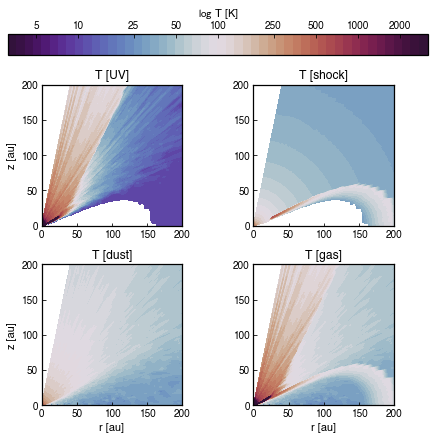

In [173]:
plot_all_temp(dd1,rlim=200)

In [18]:
def get_molecule_info(names=['co'],outdir=models_dir):
    leiden_url = 'https://home.strw.leidenuniv.nl/~moldata/datafiles/'
    co_molecules = dict(zip(['co','13co','c17o','c18o'],['co','13co','c17o','c18o']))
    shock_tracers = dict(zip(['sio-hot','sio','so'],['sio-h2-highT','sio-h2','so@lique']))
    if os.getcwd() != outdir:
        os.chdir(outdir)
    for name in names:
        if name in co_molecules.keys():
            molecule = co_molecules[name]
        elif name in shock_tracers.keys():
            molecule = shock_tracers[name]
        else:
            molecule = name
        molecule_url = leiden_url + molecule + '.dat'
        molecule_file = 'molecule_'+ name + '.inp'
        if os.path.exists(molecule_file) != True:
            if os.uname().sysname.lower().startswith('darwin'):
                os.system("curl {} -o {}".format(molecule_url, molecule_file))
            else:
                os.system("wget -0 {} {}".format(molecule_file, molecule_url))
        else:
            print('molecule file: {} exists in {}'.format(molecule_file,outdir))
    


In [137]:
def prep_line_transfer(output,molecules={'co':{}},heated=False,envelope=True):
    model = output.m
    get_molecule_info(names=molecules.keys(),outdir=model.outdir)
    write_dust_density(model,envelope=envelope)
    write_molecule_density(output, molecules=molecules)
    write_lines(model)
    write_velocities(model)
    if heated == True:
        calc_gas_T(output)
        write_gas_temperature(model,output.T['gas'])
        write_main(output.m,scat=0,dustoff=True,linesoff=False,noheat=0)

In [138]:
prep_line_transfer(dd1,heated=True)

molecule file: molecule_co.inp exists in /Users/aleksandra/Desktop/wedgeford/m1_test/


In [119]:
def write_molecule_density(output,molecules={'co':{}}):
    model = output.m
    for name in molecules.keys():
        molecule_field = get_abundances(output,name,molecule_info=molecules[name])
        Nr = np.prod(np.array(model.grid['N']))
        with open(model.outdir+'numberdens_' + name + '.inp','w+') as f:
            f.write('1\n')                   # Format number
            f.write('%d\n'%(Nr))             # Number of cells
            data = molecule_field.swapaxes(0,1).ravel(order='F') # radmc assumes 'ij' indexing for some reason
           # Create a 1-D view, fortran-style indexing
            data.tofile(f, sep='\n', format="%13.6e")
            f.write('\n')

In [118]:
def get_abundances(output, name = 'co', molecule_info={}):
    model = output.m
    co_molecules = {}
    co_molecules['co'] = {'Xism':1e-4,'T_f':20,'lam_pd':0.11}
    co_molecules['13co'] = {'Xism':1.43e-6,'T_f':20,'lam_pd':0.11}
    co_molecules['c17o'] = {'Xism':5.05e-8,'T_f':20, 'lam_pd':0.11}
    co_molecules['c18o'] = {'Xism':1.79e-7,'T_f':20, 'lam_pd':0.11}
    if name in co_molecules.keys():
        molecule_info = co_molecules[name]
    if output.T == {}:
        output.T2D()
    output.rho2D()
    n_H = output.rho['gas']/(mu*mh)
    molecule_field = n_H*molecule_info['Xism']
    molecule_field[output.T['dust'] < molecule_info['T_f']] = 0.0 #freeze out
    if 'uv' not in output.J.keys():
        output.Jnu(field='uv')
    nG0 = (4*pi*output.integrate_intensity(field='uv'))/G0_draine
    pdiss = np.log10(nG0/(2*n_H))
    molecule_field[pdiss > np.log10((molecule_info['lam_pd']/0.11))] = 0.0 #photodissociation
    return np.repeat(np.expand_dims(molecule_field.T,-1),len(model.phi),-1)
    
                   
    
    
    
    
    
        

In [117]:
def write_lines(model,names=['co']):
    with open(model.outdir+'lines.inp','w+') as f:
        f.write('2\n')                   # Format number
        f.write('{}\n'.format(len(names)))             # Number of molecules
        for name in names:
            f.write('{} leiden 0 0 0\n'.format(name))

In [136]:
def write_gas_temperature(model,Tgas):
    if Tgas.ndim != 3:
        Tgas = np.repeat(np.expand_dims(Tgas,axis=-1),len(model.phi),axis=-1)
    Nr = np.prod(np.array(model.grid['N']))
    with open(model.outdir+'gas_temperature.inp','w') as f:
        f.write('1\n')                   # Format number
        f.write('%d\n'%(Nr))             # Number of cells
        data = Tgas.swapaxes(0,1).ravel(order='F') # radmc assumes 'ij' indexing for some reason
        data.tofile(f, sep='\n', format="%13.6e")

In [115]:
def write_velocities(model):
    velocities = model.v_embedded()
    Nr = np.prod(np.array(model.grid['N']))
    with open(model.outdir+'gas_velocity.inp','w+') as f:
        f.write('1\n')                   # Format number
        f.write('%d\n'%(Nr))             # Number of cells
        vr = velocities['r'].swapaxes(0,1).ravel(order='F')
        vth = velocities['theta'].swapaxes(0,1).ravel(order='F')
        vphi = velocities['phi'].swapaxes(0,1).ravel(order='F')
        for i,j,k in zip(vr,vth,vphi):
            f.write("%9e %9e %9e\n" % (i, j, k))

### Make your new grid for the chemistry

In [5]:
write_out(d1)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


/Users/aleksandra/Desktop/wedgeford/models/make_model.py:160: RuntimeWarning: divide by zero encountered in true_divide
  r = Rc*(np.sin(th0)**2)/(1. - (np.cos(th)/np.cos(th0)))


Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


'model.out'

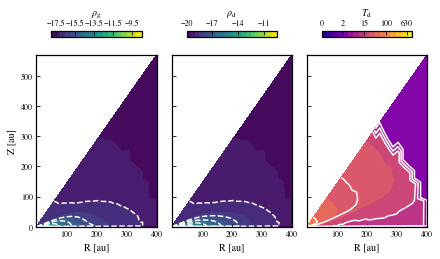

In [20]:
f, ax = subplots(1,3,constrained_layout=True)
f.set_size_inches((6,3.5))
grid = False
os.chdir(d1.outdir)
for col,prop,cmap,label in zip(ax,['rhog','rhod','Td'],['viridis','viridis','plasma'],[r'$\rho_{\rm g}$',r'$\rho_{\rm d}$',r'$T_{\rm d}$']):
    sca(col)
    plot_out(prop=prop,cmap=cmap,levels=20)
    cbar = colorbar(ax=col,location='top',shrink=0.75,aspect=8,label=label)
    if prop == 'Td':
        cbar.set_ticks(cbar.get_ticks()[::2])
        cbar.set_ticklabels((10**np.array(cbar.get_ticks())).astype(int).astype(str))
    else:
        cbar.set_ticks(cbar.get_ticks()[::2])
    plot_out(prop=prop,method=contour,colors='white',levels=10)
    axis('scaled')
    xlabel('R [au]')
    if col == ax[0]:
        ylabel('Z [au]')
    else:
        col.yaxis.set_major_formatter(NullFormatter())
    d2 = read_out()
    if grid == True:
        plot(d2['r'].flatten(),d2['z'].flatten(),'w,',alpha=0.5) #grid points
    
            

In [61]:
uvfiletest = '../highenergy_RT/uv_photons_0.03Mslg_0.5m_0.1dg_uv_e1.dat'
def Tgas_from_UV(outname='model.out',uvfile='uv_photons.dat'):
    data = read_out(outname)
    n_points = len(data['r'].flatten())
    n_r = np.shape(data['rhod'])[0]
    n_z = np.shape(data['rhod'])[1]
    
    lvec = np.linspace(1,108,108)*10+920 #wavelength (Angstroms)
    evec = h*c/(lvec*1e-8) #energy
    
    all_flux = np.zeros((n_r,n_z))
    n_rchunk = 111 
    
    def integrate_spectrum(photons):
        evec2d = np.tile(evec,(np.shape(photons)[-1],1)).T
        integral = np.trapz(photons*evec2d,x=lvec,axis=0)/G0 #in units of Habings
        return integral
    
    for j in range(n_r):
        spectra = np.genfromtxt(uvfile,skip_header=4+j*n_rchunk,max_rows=108)
        photons = spectra[:,1:]
        integral = integrate_spectrum(photons)
        all_flux[j,:] += integrate_spectrum(photons)
        
    NH2 = data['rhog']/(mu*mh) #gas density in n mol.
    NH = 2.0*NH2 # gas density in n atom
    x = np.log10(NH/1e5)
    x[x>9.2920]=9.29199  # Max density where this works is ~1e14 cm^-3.

    all_flux = np.clip(all_flux, a_min=0, a_max=None)
    delT = 420.2*(all_flux/1e3)**(1.05-0.113*x)*1.0/(10**(0.486*x-0.014*x**2)) # change in temperature based on integral
    delT[NH<1e-2] = 0.0 #set to 0 for threshhold low density
    
    data['Tg'] = np.clip(data['Td']+delT,a_min=None,a_max= 4200.) #modify calculated T diff from dust T
    return data
        
#Tgas_from_UV(uvfile=uvfiletest)


In [33]:
def cosmic_ray_zeta(outname = 'model.out',cr_model='m02'):
    data = read_out(outname)
    def zetaeval(ncol,model=cr_model):
        labels = ['m02','w98','ssm','ssx','ttm','ttx']
        #Rates from Cleeves et al. 2014
        #zeta_powerlaw alpha zeta_exponential Sigma
        allrts = np.array([[6.8e-16,3.7e-18,0.423,210.0],
            [2.0e-17,9.4e-19,0.021,260.0],
            [1.1e-18,3.0e-19,-0.00,260.0],
            [1.6e-19,7.5e-20,-0.01,250.0],
            [7.0e-21,4e-21,-0.01,290.0],
            [1.1e-22,3e-23,-0.02,490.0]])

        modin = labels.index(model)
        zp = allrts[modin,0]
        ze = allrts[modin,1]
        al = allrts[modin,2]
        co = allrts[modin,3]
        mumult = 2.36
        piv = 1e20
        F = zp*ze*mumult/(ze*mumult*(ncol/piv)**al+zp*(exp(ncol*2.0*mh/co)-1)) #C13 eq5
        return F
    
    Ncol_external = 1e10 #column before disk surface
    
    rhog = data['rhog']
    axis = 1
    rpts = np.unique(data['r'])
    zmin = 1e-10
    zc = data['z']
    dzz = 0.18741465494412662 #delta z/z for 50 bins 
    dz = zc*dzz*AU
    rhog_los = np.append(np.flip(rhog,axis=axis),rhog,axis=axis)
    dz_los = np.append(np.flip(dz,axis=axis),dz,axis=axis)
    Ncol_zpos = np.cumsum(rhog_los*dz_los,axis=axis)/(mu*mh) + Ncol_external
    Ncol_zneg = np.cumsum(np.flip(rhog_los*dz_los,axis=axis),axis=axis)/(mu*mh) + Ncol_external
    zeta = 0.5*zetaeval(Ncol_zpos,model=cr_model) + 0.5*zetaeval(Ncol_zneg,model=cr_model)
    data['zeta'] = zeta[:,:50]
    return data

cosmic_ray_zeta()

{'r': array([[1.000000e-01, 1.000000e-01, 1.000000e-01, ..., 1.000000e-01,
         1.000000e-01, 1.000000e-01],
        [1.057000e-01, 1.057000e-01, 1.057000e-01, ..., 1.057000e-01,
         1.057000e-01, 1.057000e-01],
        [1.118000e-01, 1.118000e-01, 1.118000e-01, ..., 1.118000e-01,
         1.118000e-01, 1.118000e-01],
        ...,
        [3.578576e+02, 3.578576e+02, 3.578576e+02, ..., 3.578576e+02,
         3.578576e+02, 3.578576e+02],
        [3.783425e+02, 3.783425e+02, 3.783425e+02, ..., 3.783425e+02,
         3.783425e+02, 3.783425e+02],
        [4.000000e+02, 4.000000e+02, 4.000000e+02, ..., 4.000000e+02,
         4.000000e+02, 4.000000e+02]]),
 'z': array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 8.970000e-02,
         1.082000e-01, 1.306000e-01],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 9.480000e-02,
         1.144000e-01, 1.381000e-01],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.002000e-01,
         1.209000e-01, 1.460000e-01],
   

In [ ]:
#################################################################################
def Create_0io(dir,runnm,uv,xr,isrf,slr,st,rre,rsp,ioname):

    finp = dir+'/environ/'+runnm+'/'+ioname
    fi = open(finp,'w')
    fi.write('# input & output files:\n')
    fi.write('{:<45}'.format(rsp)+'# file with species\n')
    fi.write('{:<45}'.format(rre)+'# file with reactions\n')
    fi.write('{:<45}'.format(uv)+'# file with uvfield\n')
    fi.write('{:<45}'.format(xr)+'# file with xrfield\n')
    fi.write('{:<45}'.format(isrf)+'# file with ISRF\n')
    fi.write('{:<45}'.format(slr)+'# Radionuclide Ion Rate\n')
    fi.write('{:<45}'.format(st)+'# 2D abundance file ending\n')
    fi.close()

    for file in os.listdir(dir+'/environ/'):
        if fnmatch.fnmatch(file,runnm+'*'):
            foundfile = file
            if file != runnm:
                shutil.copy2(finp,dir+'/environ/'+foundfile+'/'+ioname)

    return


In [10]:
if not os.path.exists(outdir):
		os.makedirs(outdir)
zetacr = 1.3e-17
	for n in range(len(r)): #write a new file for each radius?
		#outfile = open(outdir+'1environ.inp.e1.'+np.round(r[n],decimals=4))
		#outfile.write('  R             rho           Tgas          Tdust        zAU           zcm           Nrz           ZetaCR        DustFrac\n')
		#outfile.write('1\n')
		#outfile.write(str(nz)+'\n')
		if n !=0 and r[n] == r[n-1]:
			nsig_unset = -3.0 *rhog[n] * dust2gas/rho_si * (amax_ism**-0.5 - amin_chem**-0.5)/ \
			(amax_ism**-0.5 - amin_chem**-0.5)
			nsig_tot = 0.0
			for d in range(ndust):
				nsig = -3.0 *rhod[d,n]/rho_si * (amax[d]**-0.5 - amin[d]**-0.5)/ \
				(amax[d]**-0.5 - amin[d]**-0.5)
				nsig_tot = nsig_tot + nsig
			dustfrac = nsig_tot/nsig_unset
			zcm = zcm + np.abs(z[n]-z[n-1])
		else:
			zcm = 1e-10
			print("new radius:",r[n],z[n])
            
    #outfile.write(' %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E   %6.2E\n'%(r[n],rhod[n],Td[n],Td[n],z[n],zcm,1e10,zetacr,dustfrac))

In [ ]:
isrf_model = 'isrf_'+isrf_vals[i]+'_half_'+env_orig[e]+'.dat'
isrf_model = 'None'
ioname = '0io.'+str(int(float(isrf_vals[i])))+'G0.x'+str(int(float(xr_vals[x])))+'.inp'
#print(diskchem_dir,env_orig[e],uv_model[e],short_env_orig[e])
Tgas_Comp(diskchem_dir,env_orig[e],uv_model[e],short_env_orig[e])
Generate_Environment(diskchem_dir,env_orig[e])
Create_0io(diskchem_dir,env_orig[e],uv_model[e],xr_model,isrf_model,slr_model[e],srt_time[e],rreac,rspec,ioname)

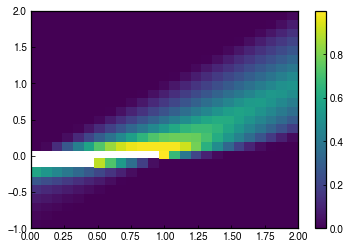

In [459]:
n = 100
Td = 10
kap_d = 3.0

kap_e = np.logspace(-1,0,n)*kap_d
Te = np.logspace(0,2,n)*Td
fm_e = np.logspace(-1,0,n)

K,T,FM = np.meshgrid(kap_e,Te,fm_e)

ftot = kap_d*Td*(1.-FM) + K*T*FM

T_infer = ftot/(kap_d*1.0)



hist2d(np.log10(T.flatten()/Td),np.log10(T_infer.flatten()/Td),bins=25,density=True,cmax=1)
colorbar()


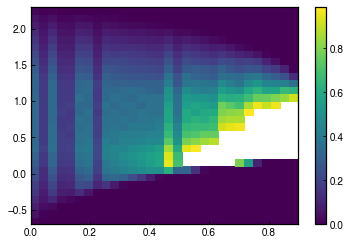

In [475]:
hist2d(1-FM.flatten(),np.log10(T_infer.flatten()/5),bins=30,density=True,cmax=1)
colorbar()

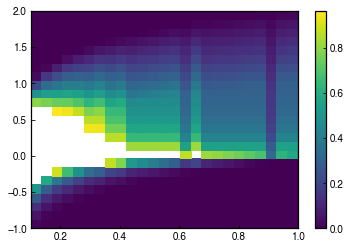

In [465]:
hist2d(K.flatten(),np.log10(T_infer.flatten()/Td),bins=25,density=True,cmax=1)
colorbar()

In [432]:
np.log10(2)

0.3010299956639812

In [435]:
10**(1.25)

17.78279410038923